In [679]:
import torch
import pickle
import matplotlib.pyplot as plt
import numpy as np
from convex_network import * 

In [681]:
with open('evp_data/2024-12-20_Viscoplastic_PC1D_process1_data.pkl', 'rb') as f:
    data = pickle.load(f)

In [167]:
E_bar = 1/np.mean(1/data['youngs_modulus'], axis=1, keepdims=True)

In [168]:
s_pred = np.zeros(data['stress'].shape)

In [686]:
xi = np.zeros((1000, 5001, 1))
dt = 1/ 5000
for i in range(data['stress'].shape[1]-1):
    increment = np.mean(E_bar**data['rate_exponent']*data['rate_constant']*np.abs(data['strain'][:,i] - xi[:,i])**data['rate_exponent']*data['yield_stress']**(-data['rate_exponent']), axis=1, keepdims=True)
    xi[:,i+1] = xi[:,i] + dt*np.sign(data['strain'][:,i] - xi[:,i])*increment
    s_pred[:,i+1] = E_bar*(data['strain'][:,i+1] - xi[:,i+1])

In [687]:
error = np.mean((s_pred - data['stress'])**2)


In [688]:
dt, error

(0.0002, 8.417327141135792e-07)

In [689]:
import util as util
import m_evp as m_evp
import importlib
util = importlib.reload(util)
m_evp = importlib.reload(m_evp)
loss_function = util.LossFunction()

In [690]:
step = 2
dataset = util.ViscoplasticDataset('evp_data/2024-12-20_Viscoplastic_PC1D_process1_data.pkl', step)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1000, shuffle=True)
evp_model = m_evp.ViscoplasticMaterialModel([1, 1],
    dt=0.0002*step)

TypeError: ViscoplasticDataset.__init__() missing 1 required positional argument: 'final_step'

In [265]:
for x,y in dataloader:
    e, E, Y, n, edot_0, = x
    
    
    y_pred,_ = evp_model(e, E, Y, n, edot_0)
    
    break

100%|██████████| 2501/2501 [01:34<00:00, 26.53it/s]


In [258]:

loss = loss_function.L2RelativeError(y_pred, y)
loss

tensor(0.0038, grad_fn=<MeanBackward0>)

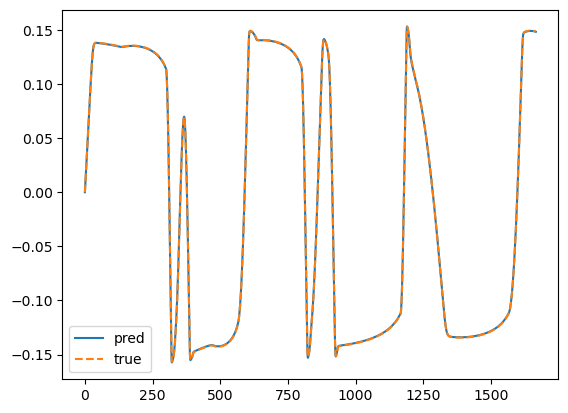

In [259]:
i = 90
plt.plot(y_pred[i].detach().numpy(), label='pred')
plt.plot(y[i].detach().numpy(), '--', label='true')
plt.legend()


In [636]:
x = torch.randn(1000, 1)
n = torch.rand(1000, 1)*10 + 1
p = lambda n: n + 0.5*torch.sin(n)
out = (torch.abs(x)**p(n))

In [641]:
class PowerLayer(torch.nn.Module):
    def __init__(self):
        super(PowerLayer, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(1, 10),
            torch.nn.Softplus(),
            torch.nn.Linear(10, 10),
            torch.nn.Softplus(),
            torch.nn.Linear(10, 1)
        )
        
    def forward(self, x, n):
        return torch.abs(x)**self.model(n)

In [642]:
model = PowerLayer()

In [655]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.5e-3)


In [678]:
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    out_pred = model(x, n)
    loss = torch.nn.functional.mse_loss(out_pred, out)
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 14.643828392028809
Epoch 1000, Loss: 11.273147583007812
Epoch 2000, Loss: 11.328102111816406
Epoch 3000, Loss: 11.107769966125488
Epoch 4000, Loss: 11.006793022155762
Epoch 5000, Loss: 14.228135108947754
Epoch 6000, Loss: 13.350369453430176
Epoch 7000, Loss: 10.744211196899414
Epoch 8000, Loss: 69.39474487304688
Epoch 9000, Loss: 10.632708549499512


In [672]:
x_test = torch.linspace(-2, 2, 1000).reshape(-1, 1)
n_test = torch.tensor([[2.0]]).repeat(1000, 1)
out_test = torch.abs(x_test)**p(n_test)

In [673]:
x_test.shape, out_test.shape

(torch.Size([1000, 1]), torch.Size([1000, 1]))

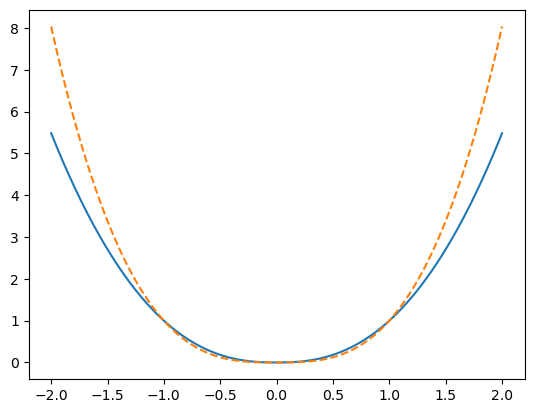

In [674]:
plt.plot(x_test.detach().numpy()[:,0], out_test.detach().numpy()[:,0], label='true')
out_pred_test = model(x_test, n_test)
plt.plot(x_test.detach().numpy()[:,0], out_pred_test.detach().numpy()[:,0], '--', label='pred')